# An Introduction to Markov Chain Monte Carlo

### Or: How to Take a Principled Moral Stance Against Integration

When I was a mathematics undergraduate, I hated integration. Seeing that "S" sign with that innocent-looking "dx" at the end filled me with the worst kind of dread. It brought flashbacks of trying desperately to find the correct substitution, of attempting to do it by parts and ending up with something worse, of scratching my head looking up trigonometric integral identities, of finally giving in and typing it into WolframAlpha with a prayer that I could at least vaguely understand the output.

After many a day spent fretting over volumes, surfaces, line integrals, I came to a realisation: if I just stayed away from all of the physics courses, and politely ignored complex analysis, I could get to a point where I would never have to do an integral ever again. After all, statistics was much more of my thing. I could live my life happily integral-free.

But then came the horrifying realisation:

*In order to draw a sample from a one-dimensional normal distribution, you need to integrate the normal density function.*

Whatever could I do? So much of stats is based off of normal distributions, and here was my worst enemy sitting coolly behind it all. No matter how many mathematical abstractions or software packages it was wrapped up in to keep it from my sight, it was there. I could not morally claim to "hate integration" while still reaping its benefits in everything I do. I would be a hypocrite!

If only there was some way to, I don't know, sample a normal distribution in an entirely integral-free manner...

The Hypocritical Method: 
Just Because You Can't See The Integration Doesn't Mean It Isn't There


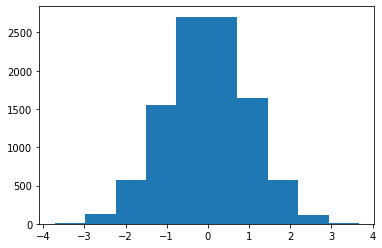

In [18]:
%matplotlib inline
import scipy.stats
import matplotlib.pyplot as plt

normal_sample = scipy.stats.norm.rvs(size=10000)

print("The Hypocritical Method: \nJust Because You Can't See The Integration Doesn't Mean It Isn't There")
plt.hist(normal_sample)
plt.show()

## The Lazy Way Out

Now, the easiest way to do this would be to use the Central Limit Theorem.

* I'm assuming that it is possible to generate random Uniform(0, 1) variables (using any standard random number generator out there - and no, they don't use integration, they use modular arithmetic: I might go into how they work in a future blog post).
* I'm allowing for the possibility that my sample is not exact, but merely accurate to within (say) 3 significant figures.

Given these two facts, if I want to make a normal random variable, I should just take N=100 uniform random variables, sum them up, subtract N\*1/2=50, divide by sqrt(N\*1/12), and I'll have something that looks like a normal random variable for all practical purposes.

However... in case you haven't already guessed, I don't *actually* hate integration (...much). I'm merely using this moral crusade as an opportunity to introduce you all to a very cool mathematical trick that can be applied to draw samples from a wide variety of distributions, some of which it's impossible to integrate, and none of which (apart from the normal) have a Central Limit Theorem to help us out.

But for the sake of completeness, let's go the easy route first.

The Lazy Method: 
This Only Works For Normal Distibutions


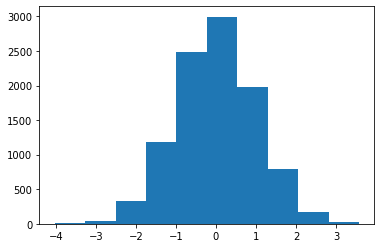

array([ 0.16779402, -1.12715113, -0.39819663, ..., -0.99649855,
       -0.66142775,  0.17914952])

In [33]:
import numpy as np

N = 100
mean = N * 1/2
sd = np.sqrt(N * 1/12)

uniform_sample = scipy.stats.uniform.rvs(size=(N, 10000))
summed_sample = np.sum(uniform_sample, axis=0)
normal_sample = (summed_sample - mean)/sd

print("The Lazy Method: \nThis Only Works For Normal Distibutions")
plt.hist(normal_sample)
plt.show()

## Rejection Sampling

"Okay", you think. "Well, if we want something that eventually works with lots of different distibutions, we need to make some kind of use of the information about the distribution in our method". What kind of information do we have access to about our distribution? The density function f(x). We don't have the cumulative distribution function (because that would require integration, *the horror*) and for similar reasons we don't have the mean, median, or variance either. We do have the mode M = sup(f(x)) though.

Suppose we are prepared to pretend that no normal random variable takes a value outside the range \[-5, +5\]. This is a lie, of course, but it's not a very easy lie to discover: [five-sigma events](https://blogs.scientificamerican.com/observations/five-sigmawhats-that/) are generally considered "rare enough to be discounted for all practical purposes" by the scientific community when they are, for example, discovering new particles.

Given this, we can use a different algorithm which consists of two steps: a *proposal* step and an *accept/reject* step. We "propose" a value x for the normal random variable by drawing from a Uniform(-5, 5) distribution, and then accept with probability f(x)/M (using a Uniform(0, 1) to test this). If we reject, we propose a new value, and so on until we find an acceptable one. Note that we could use any value greater than M in this formula, but to do so would slow down our algorithm by making us less likely to accept.

This way, if a point x is "twice as likely" as a point y to be generated from a normal distribution, it's "equally as likely" to be generated from a uniform distibution (because it's uniform) and twice as likely to then be accepted. So our results should end up looking normal.

Naive Accept-Reject: 
Let's Hope Nobody Notices The Lack of Five-Sigma Events


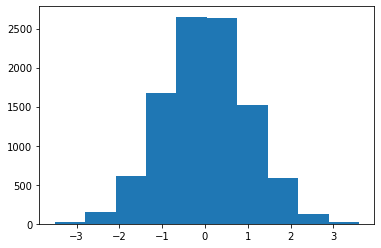

In [40]:
def generate_normal(_):
    
    while True:
        #Proposal step
        proposal = scipy.stats.uniform.rvs() * 10 - 5
        
        #Accept-reject step
        acceptance_prob = scipy.stats.norm.pdf(proposal) * np.sqrt(2 * np.pi) #mode of standard normal
        if scipy.stats.uniform.rvs() < acceptance_prob:
            return proposal
    
array = np.zeros(10000)
normal_sample = np.vectorize(generate_normal)(array)

print("Naive Accept-Reject: \nLet's Hope Nobody Notices The Lack of Five-Sigma Events")
plt.hist(normal_sample)
plt.show()

## The Random Walk Method

So, we're very nearly onto something. There are two problems with the above:

* We're lying to ourselves by pretending that no five-sigma events ever happen.
* Our choice of \[-5, +5\] was informed by our knowledge of the variance of the distribution, which we can't obtain without integrating (*oh no!*).

Unfortunately it's not possible to draw a random variable "uniformly on the real line", so we need to have some threshold. And if we set the threshold at, say, \[-100, +100\], then almost every proposal we make would be rejected, and it would take a long time to generate our samples.

But wait: we don't have to have the threshold interval centred on 0, and we don't have to set the same threshold interval for every draw! If we had a way to set threshold intervals that somehow "looked like our distribution", then we'd be able to use them to easily generate samples.

Ah, bummer. In order to set threshold intervals that look like our distribution, we need to have samples in the first place. Although... we do have samples, because we just generated them.

This is the basis of the Random Walk method. It goes like this:

* Fix a tuning parameter t (=1) and a starting value s (=0)
* Draw a "normal-ish" sample n1 from the interval \[s-t, s+t\] using accept-reject.
* Draw another "normal_ish" sample n2 from \[n1-t, n1+t\].
* Continue as long as you like.

The normal samples will "walk randomly" around the real line, which means they'll cover everywhere eventually. And if you're for example in the interval \[6, 8\], then the acceptance probabilities can be increased by only dividing by the "local mode".

Random Walk: 
Are we done yet?


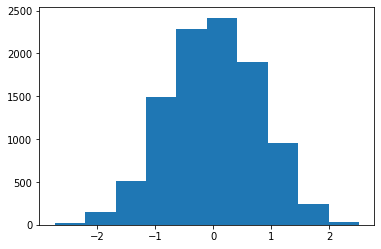

In [45]:
def generate_normal_random_walk(n, t=1):
    
    while True:
        #Proposal step
        proposal = scipy.stats.uniform.rvs() * 2 * t - 1 + n
        
        #Accept-reject step
        if n+t<0 and n-t >0:
            local_mode = 1/np.sqrt(2 * np.pi)
        else:
            local_mode = max(scipy.stats.norm.pdf(n+t), scipy.stats.norm.pdf(n-t))
        
        acceptance_prob = scipy.stats.norm.pdf(proposal) / local_mode
        if scipy.stats.uniform.rvs() < acceptance_prob:
            return proposal
    
s=0
normal_sample = [s]
for i in range(10000):
    normal_sample.append(generate_normal_random_walk(normal_sample[i]))

print("Random Walk Method: \nAre we done yet?")
plt.hist(normal_sample)
plt.show()

## The Curse of Correlation

What we just did was pretty groovy, but the histogram belies a dark fact: these may be normal samples, but they're not *independent* normal samples. Each value can only vary by +/- t from the preceding value. (This is why picking t can be very important, and represents a tradeoff between large computation times and good mixing). This means that we might not get "rare" values as often as we should - look at the histogram, and notice that there's fewer outliers here than before.

In maths-speak, what we've just done is to construct a *Markov Chain* with a *stationary distribution* that is what we want to draw samples from (in this case, a normal distribution) and then run the chain until it starts looking like the stationary distibution. Examining how well the chain mixes can be very important, and we can do this via an auto-correlation plot.

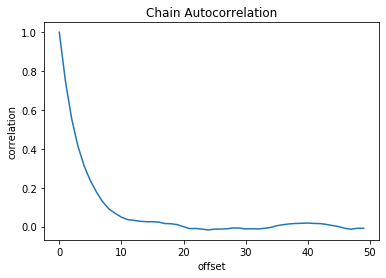

In [48]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    s = result.size // 2
    return result[s:s+50]/result[s]

plt.plot(autocorr(normal_sample))
plt.xlabel("offset")
plt.ylabel("correlation")
plt.title("Chain Autocorrelation")
plt.show()

From this plot, it's clear that (for this distribution and value of t) once you get to about 20 iterations of the chain away, the value you have is pretty uncorrelated from the value you started with. (You can statistically test for this, but the graph is pretty telling). So, just throw away everything apart from every 20th value, and you're good. You can use this graph to pick a good t.

It turns out that if you're throwing away data like this, you don't even need to bother with the "keep proposing until we accept" loop and can just return the value you're proposing from if you're very lazy.

Pruned Random Walk Method: 
Ok, we're finally done.


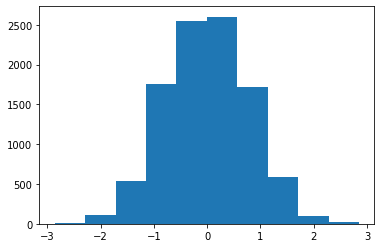

In [49]:
s=0
unpruned_normal_sample = [s]
normal_sample = []
for i in range(200000):
    x = generate_normal_random_walk(unpruned_normal_sample[i])
    unpruned_normal_sample.append(x)
    if i%20==0:
        normal_sample.append(x)

print("Pruned Random Walk Method: \nOk, we're finally done.")
plt.hist(normal_sample)
plt.show()

This method is called a Markov Chain Monte Carlo method, specifically the [Metropolis Random Walk](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). We have done no integration whatsoever, and used only the density function, in order to draw samples from a probability distribution defined by that density. Pretty neat, huh?
